In [1]:
import torch
import torch.nn as nn

class res_block(nn.Module):
  def __init__(self, in_channels=64, out_channels=32, stride=1, downsample=None, expansions=1):
    super(res_block, self).__init__()
    in_channels = in_channels * expansions
    out_channels = out_channels * expansions
    self.conv1 = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, ),
                    nn.BatchNorm2d(out_channels),
                    nn.LeakyReLU(inplace=False))
    self.conv2 = nn.Sequential(
                    nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(in_channels),
                    nn.LeakyReLU(inplace=False))
  def forward(self, x):
      residual = x
      out = self.conv1(x)

      out = self.conv2(out)

      out += residual


      return out




In [2]:
from torch.nn.modules.activation import LeakyReLU
class ResNet(nn.Module):
  def __init__(self, block, ):
    super(ResNet, self).__init__()
    self.conv1 = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU(inplace=False),)

    self.block0 = self._make_block(block, sample = 1 ,repeats = 1, expansion=1)
    self.block1 = self._make_block(block, sample = 2, repeats = 2, expansion=2)
    self.block2 = self._make_block(block, sample = 4 ,repeats = 8, expansion=4)
    self.block3 = self._make_block(block, sample = 8, repeats = 8, expansion=8)
    self.block4 = self._make_block(block, sample = 16, repeats = 4, expansion=16)

  def _make_block(self, block, sample = 0, repeats=0, expansion=0):
    layers = []

    downsample = nn.Sequential(
        nn.Conv2d(32*sample, 64*sample, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64*sample),
        nn.LeakyReLU(inplace=False), )
    layers.append(downsample)

    for i in range(repeats):
      layers.append(block(expansions=expansion))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    b0 = self.block0(x)
    b1 = self.block1(b0)

    b2 = self.block2(b1)
    b3 = self.block3(b2)

    b4 = self.block4(b3)


    return b4, b3, b2



In [22]:
from torch.nn.modules.pooling import AvgPool2d
from os import pread
import torch.nn.functional as F
class yolov3(nn.Module):
  def __init__(self, ResNet):
    super(yolov3, self).__init__()

    self.ResNet = ResNet
    self.DB1 = self._make_db1()
    self.output1 = self._final_layer(512, 1024)

    self.db2_conv = self._make_db(512, 256)
    self.DB2 = self._make_db2()
    self.output2 = self._final_layer(256, 512)

    self.db3_conv = self._make_db(256, 128)
    self.DB3 = self._make_db3()
    self.output3 = self._final_layer(128, 256)

  def _make_db(self, input, output):
    return nn.Sequential(
        nn.Conv2d(input, output, kernel_size=1),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(inplace=False)
    )
  def _make_db1(self,):
    return nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=1, stride=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(1024, 512, kernel_size=1, stride=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(1024, 512, kernel_size=1, stride=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=False)


    )
  def _make_db2(self,):
    return nn.Sequential(
        nn.Conv2d(768, 256, kernel_size=1, stride=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(512, 256, kernel_size=1, stride=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(512, 256, kernel_size=1, stride=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=False)


    )
  def _make_db3(self,):
    return nn.Sequential(
        nn.Conv2d(384, 128, kernel_size=1, stride=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(256, 128, kernel_size=1, stride=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(256, 128, kernel_size=1, stride=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=False)
    )

  def _final_layer(self, input, output):
    return nn.Sequential(
        nn.Conv2d(input, output, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(inplace=False),

        nn.Conv2d(output, 18, kernel_size=1, stride=1),

    )
  def forward(self, images, targets=None, anchors=None):

    x = self.ResNet(images)
    out1 = self.DB1(x[0])

    db2conv = self.db2_conv(out1)
    upsampled_one = F.interpolate(db2conv, (26,26), mode='nearest')
    concat_one = torch.cat( (x[1], upsampled_one), dim=1 )
    out2 = self.DB2(concat_one)

    db3conv = self.db3_conv(out2)
    upsampled_two = F.interpolate(db3conv, (52,52), mode='nearest')
    concat_two = torch.cat( (x[2], upsampled_two), dim=1)
    out3 = self.DB3(concat_two)

    output_b = self.output1(out1).permute(0,2,3,1).view(-1, 13, 13, 3, 6)
    output_m = self.output2(out2).permute(0,2,3,1).view(-1, 26, 26, 3, 6)
    output_s = self.output3(out3).permute(0,2,3,1).view(-1, 52, 52, 3, 6)


    loss_outputs = output_preprocessing(output_s, output_m, output_b, targets, images, anchors)



    return (loss_outputs['offset_loss'] * 2.0 + loss_outputs['obj_loss']+
            loss_outputs['noobj_loss'] * 0.4), loss_outputs



In [20]:
8%4

0

In [4]:
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import torch
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt


def train_epocs(model, optimizer, data_loader, devie, all_anchors ,epochs=30,training_state=False ):

    for epoch in range(epochs):
        if epoch==30:
           parameters = model.parameters()
           optimizer = torch.optim.SGD(parameters, lr = 0.000002,
                                       momentum=0.99)
        total = 0
        sum_loss = 0
        sum_loss_classifier = 0
        sum_loss_offsets = 0
        sum_loss_noobj = 0
        sum_loss_obj = 0

        iteration_num = 0

        for i, data in enumerate(tqdm(data_loader)):
            images = data[0].to(device)
            targets = data[1]
            batch_length = len(images)
            ### gradient tracking
            if not training_state:
               with torch.no_grad():
                  model.eval()
                  output = model(images, targets = targets, anchors = all_anchors)
            else:
                 model.train()
                 output = model(images, targets, all_anchors)
            Final_loss = output[0]
            Final_loss.backward()
            if training_state and i%4==0:
               optimizer.step()
               optimizer.zero_grad()


            iteration_num += 1
            total += batch_length

            sum_loss += output[0]
            #sum_loss_classifier += output[1]
            sum_loss_offsets += output['offset_loss']
            sum_loss_noobj += output['noobj_loss']
            sum_loss_obj += output['obj_loss']

            if iteration_num % 50 == 0:

                train_loss = sum_loss/total
                train_loss_classifier = sum_loss_classifier/total
                train_loss_offsets = sum_loss_offsets/total
                train_loss_noobj = sum_loss_noobj/total
                train_loss_obj = sum_loss_obj/total
                print("loss %.6f classifer %.6f regressor %.6f noobj_loss %.6f obj_loss %.6f "%
                      (train_loss, train_loss_classifier, train_loss_offsets, train_loss_noobj, train_loss_obj))
                total = 0.0
                sum_loss= 0.0
                sum_loss_classifier = 0.0
                sum_loss_offsets = 0.0
                sum_loss_noobj = 0.0
                sum_loss_obj = 0.0


    return model


In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
resnet = ResNet(res_block)
model = yolov3(resnet).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3 , momentum = 0.99)
print(device)


cuda


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/yolov3.pth')

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/yolov3.pth', map_location=device))






<All keys matched successfully>

In [ ]:
train = train_epocs(model, optimizer, data_loader, device, all_anchors, epochs=20 ,training_state=True)





  9%|▉         | 50/567 [00:41<08:14,  1.04it/s]

loss 0.060379 classifer 0.000000 regressor 0.627225 noobj_loss 0.102501 obj_loss 0.236341 


 18%|█▊        | 100/567 [01:25<08:35,  1.10s/it]

loss 0.040832 classifer 0.000000 regressor 0.333885 noobj_loss 0.111019 obj_loss 0.208406 


 26%|██▋       | 150/567 [02:09<08:37,  1.24s/it]

loss 0.041363 classifer 0.000000 regressor 0.367745 noobj_loss 0.122980 obj_loss 0.171082 


 35%|███▌      | 200/567 [02:52<06:06,  1.00it/s]

loss 0.046570 classifer 0.000000 regressor 0.471931 noobj_loss 0.138262 obj_loss 0.134925 


 44%|████▍     | 250/567 [03:35<05:11,  1.02it/s]

loss 0.044964 classifer 0.000000 regressor 0.452187 noobj_loss 0.152303 obj_loss 0.114941 


 53%|█████▎    | 300/567 [04:18<04:19,  1.03it/s]

loss 0.042622 classifer 0.000000 regressor 0.421182 noobj_loss 0.160980 obj_loss 0.099785 


 62%|██████▏   | 350/567 [05:01<03:29,  1.03it/s]

loss 0.071927 classifer 0.000000 regressor 0.897820 noobj_loss 0.170627 obj_loss 0.082384 


 71%|███████   | 400/567 [05:45<02:48,  1.01s/it]

loss 0.045803 classifer 0.000000 regressor 0.473885 noobj_loss 0.178341 obj_loss 0.080619 


 79%|███████▉  | 450/567 [06:29<01:58,  1.02s/it]

loss 0.044699 classifer 0.000000 regressor 0.459829 noobj_loss 0.179434 obj_loss 0.075914 


 88%|████████▊ | 500/567 [07:12<01:08,  1.02s/it]

loss 0.045185 classifer 0.000000 regressor 0.463125 noobj_loss 0.181464 obj_loss 0.078368 


 97%|█████████▋| 550/567 [07:55<00:19,  1.14s/it]

loss 0.042975 classifer 0.000000 regressor 0.435182 noobj_loss 0.182209 obj_loss 0.070214 


  9%|▉         | 50/567 [00:42<08:25,  1.02it/s]

loss 0.045066 classifer 0.000000 regressor 0.463019 noobj_loss 0.184749 obj_loss 0.073292 


 18%|█▊        | 100/567 [01:25<07:32,  1.03it/s]

loss 0.042525 classifer 0.000000 regressor 0.416659 noobj_loss 0.181688 obj_loss 0.082060 


 26%|██▋       | 150/567 [02:08<06:45,  1.03it/s]

loss 0.043049 classifer 0.000000 regressor 0.427984 noobj_loss 0.181499 obj_loss 0.079294 


 35%|███▌      | 200/567 [02:51<05:53,  1.04it/s]

loss 0.042665 classifer 0.000000 regressor 0.425362 noobj_loss 0.186446 obj_loss 0.070832 


 44%|████▍     | 250/567 [03:34<05:31,  1.05s/it]

loss 0.043583 classifer 0.000000 regressor 0.439572 noobj_loss 0.183284 obj_loss 0.074476 


 53%|█████▎    | 300/567 [04:17<04:31,  1.02s/it]

loss 0.040747 classifer 0.000000 regressor 0.394347 noobj_loss 0.181452 obj_loss 0.076150 


 62%|██████▏   | 350/567 [05:00<03:32,  1.02it/s]

loss 0.041904 classifer 0.000000 regressor 0.412554 noobj_loss 0.180064 obj_loss 0.077852 


 71%|███████   | 400/567 [05:43<02:43,  1.02it/s]

loss 0.043029 classifer 0.000000 regressor 0.428909 noobj_loss 0.177622 obj_loss 0.081925 


 79%|███████▉  | 450/567 [06:26<01:54,  1.02it/s]

loss 0.047879 classifer 0.000000 regressor 0.507174 noobj_loss 0.175892 obj_loss 0.082998 


 88%|████████▊ | 500/567 [07:09<01:05,  1.03it/s]

loss 0.042779 classifer 0.000000 regressor 0.428838 noobj_loss 0.173633 obj_loss 0.081989 


 97%|█████████▋| 550/567 [07:52<00:16,  1.03it/s]

loss 0.043799 classifer 0.000000 regressor 0.436379 noobj_loss 0.172281 obj_loss 0.092128 


  9%|▉         | 50/567 [00:42<08:36,  1.00it/s]

loss 0.043917 classifer 0.000000 regressor 0.446208 noobj_loss 0.172422 obj_loss 0.084035 


 18%|█▊        | 100/567 [01:26<07:52,  1.01s/it]

loss 0.043192 classifer 0.000000 regressor 0.435943 noobj_loss 0.173345 obj_loss 0.081791 


 26%|██▋       | 150/567 [02:10<07:08,  1.03s/it]

loss 0.042615 classifer 0.000000 regressor 0.423043 noobj_loss 0.172471 obj_loss 0.086322 


 35%|███▌      | 200/567 [02:52<06:04,  1.01it/s]

loss 0.041902 classifer 0.000000 regressor 0.410863 noobj_loss 0.172810 obj_loss 0.086754 


 44%|████▍     | 250/567 [03:35<05:11,  1.02it/s]

loss 0.041513 classifer 0.000000 regressor 0.407965 noobj_loss 0.170120 obj_loss 0.086122 


 53%|█████▎    | 300/567 [04:18<04:17,  1.04it/s]

loss 0.042455 classifer 0.000000 regressor 0.424251 noobj_loss 0.169241 obj_loss 0.085784 


 62%|██████▏   | 350/567 [05:01<03:40,  1.02s/it]

loss 0.042801 classifer 0.000000 regressor 0.427220 noobj_loss 0.170920 obj_loss 0.086684 


 71%|███████   | 400/567 [05:44<02:41,  1.03it/s]

loss 0.042598 classifer 0.000000 regressor 0.424282 noobj_loss 0.173286 obj_loss 0.084004 


 79%|███████▉  | 450/567 [06:27<01:59,  1.02s/it]

loss 0.041797 classifer 0.000000 regressor 0.413324 noobj_loss 0.176605 obj_loss 0.078830 


 88%|████████▊ | 500/567 [07:10<01:04,  1.03it/s]

loss 0.041800 classifer 0.000000 regressor 0.409608 noobj_loss 0.175811 obj_loss 0.083388 


 97%|█████████▋| 550/567 [07:53<00:17,  1.01s/it]

loss 0.042033 classifer 0.000000 regressor 0.415149 noobj_loss 0.172882 obj_loss 0.084492 


  9%|▉         | 50/567 [00:42<08:42,  1.01s/it]

loss 0.042688 classifer 0.000000 regressor 0.422964 noobj_loss 0.169152 obj_loss 0.090897 


 18%|█▊        | 100/567 [01:25<07:39,  1.02it/s]

loss 0.042473 classifer 0.000000 regressor 0.424125 noobj_loss 0.168974 obj_loss 0.086470 


 26%|██▋       | 150/567 [02:07<06:49,  1.02it/s]

loss 0.041700 classifer 0.000000 regressor 0.409277 noobj_loss 0.170206 obj_loss 0.087722 


 35%|███▌      | 200/567 [02:51<05:58,  1.02it/s]

loss 0.041760 classifer 0.000000 regressor 0.410528 noobj_loss 0.170756 obj_loss 0.086884 


 44%|████▍     | 250/567 [03:34<05:09,  1.02it/s]

loss 0.042359 classifer 0.000000 regressor 0.419908 noobj_loss 0.172189 obj_loss 0.085647 


 53%|█████▎    | 300/567 [04:16<04:20,  1.03it/s]

loss 0.042472 classifer 0.000000 regressor 0.421486 noobj_loss 0.173385 obj_loss 0.084678 


 62%|██████▏   | 350/567 [04:59<03:35,  1.01it/s]

loss 0.043069 classifer 0.000000 regressor 0.430453 noobj_loss 0.173236 obj_loss 0.085416 


 71%|███████   | 400/567 [05:42<02:51,  1.03s/it]

loss 0.041812 classifer 0.000000 regressor 0.415089 noobj_loss 0.172232 obj_loss 0.081672 


 79%|███████▉  | 450/567 [06:25<01:58,  1.01s/it]

loss 0.041683 classifer 0.000000 regressor 0.412727 noobj_loss 0.171559 obj_loss 0.082646 


 88%|████████▊ | 500/567 [07:08<01:06,  1.00it/s]

loss 0.042440 classifer 0.000000 regressor 0.422354 noobj_loss 0.170127 obj_loss 0.086552 


 97%|█████████▋| 550/567 [07:51<00:16,  1.03it/s]

loss 0.042685 classifer 0.000000 regressor 0.423335 noobj_loss 0.170509 obj_loss 0.089119 


  9%|▉         | 50/567 [00:42<08:26,  1.02it/s]

loss 0.043376 classifer 0.000000 regressor 0.440289 noobj_loss 0.171665 obj_loss 0.082062 


 18%|█▊        | 100/567 [01:25<07:32,  1.03it/s]

loss 0.040651 classifer 0.000000 regressor 0.393074 noobj_loss 0.170783 obj_loss 0.086560 


 26%|██▋       | 150/567 [02:08<06:45,  1.03it/s]

loss 0.042142 classifer 0.000000 regressor 0.416387 noobj_loss 0.168994 obj_loss 0.088892 


 35%|███▌      | 200/567 [02:51<05:56,  1.03it/s]

loss 0.041514 classifer 0.000000 regressor 0.409075 noobj_loss 0.166763 obj_loss 0.088387 


 44%|████▍     | 250/567 [03:34<05:23,  1.02s/it]

loss 0.041457 classifer 0.000000 regressor 0.408487 noobj_loss 0.166962 obj_loss 0.087863 


 53%|█████▎    | 300/567 [04:17<04:32,  1.02s/it]

loss 0.042359 classifer 0.000000 regressor 0.424141 noobj_loss 0.167208 obj_loss 0.086395 


 62%|██████▏   | 350/567 [05:00<03:34,  1.01it/s]

loss 0.042641 classifer 0.000000 regressor 0.429690 noobj_loss 0.165931 obj_loss 0.086638 


 71%|███████   | 400/567 [05:43<02:44,  1.02it/s]

loss 0.042536 classifer 0.000000 regressor 0.421940 noobj_loss 0.167078 obj_loss 0.091563 


 79%|███████▉  | 450/567 [06:26<01:54,  1.02it/s]

loss 0.041202 classifer 0.000000 regressor 0.400579 noobj_loss 0.168461 obj_loss 0.090185 


 88%|████████▊ | 500/567 [07:09<01:04,  1.04it/s]

loss 0.042308 classifer 0.000000 regressor 0.419069 noobj_loss 0.167919 obj_loss 0.089935 


 97%|█████████▋| 550/567 [07:52<00:16,  1.03it/s]

loss 0.042799 classifer 0.000000 regressor 0.429611 noobj_loss 0.168655 obj_loss 0.086520 


  9%|▉         | 50/567 [00:43<08:22,  1.03it/s]

loss 0.042121 classifer 0.000000 regressor 0.417235 noobj_loss 0.170416 obj_loss 0.086278 


 18%|█▊        | 100/567 [01:26<07:55,  1.02s/it]

loss 0.043601 classifer 0.000000 regressor 0.438977 noobj_loss 0.170591 obj_loss 0.088048 


 26%|██▋       | 150/567 [02:08<07:16,  1.05s/it]

loss 0.042430 classifer 0.000000 regressor 0.425812 noobj_loss 0.169635 obj_loss 0.083438 


 35%|███▌      | 200/567 [02:52<06:14,  1.02s/it]

loss 0.040906 classifer 0.000000 regressor 0.399765 noobj_loss 0.168357 obj_loss 0.086373 


 44%|████▍     | 250/567 [03:35<05:16,  1.00it/s]

loss 0.043802 classifer 0.000000 regressor 0.441906 noobj_loss 0.171588 obj_loss 0.087330 


 53%|█████▎    | 300/567 [04:17<04:27,  1.00s/it]

loss 0.043700 classifer 0.000000 regressor 0.447772 noobj_loss 0.172323 obj_loss 0.079100 


 62%|██████▏   | 350/567 [05:00<03:33,  1.02it/s]

loss 0.042738 classifer 0.000000 regressor 0.429856 noobj_loss 0.172191 obj_loss 0.081759 


 71%|███████   | 400/567 [05:43<02:43,  1.02it/s]

loss 0.042980 classifer 0.000000 regressor 0.424206 noobj_loss 0.171224 obj_loss 0.092254 


 79%|███████▉  | 450/567 [06:26<01:54,  1.02it/s]

loss 0.043995 classifer 0.000000 regressor 0.449301 noobj_loss 0.171512 obj_loss 0.083111 


 88%|████████▊ | 500/567 [07:09<01:04,  1.04it/s]

loss 0.041774 classifer 0.000000 regressor 0.417915 noobj_loss 0.168477 obj_loss 0.081986 


 97%|█████████▋| 550/567 [07:52<00:17,  1.00s/it]

loss 0.042974 classifer 0.000000 regressor 0.437886 noobj_loss 0.169696 obj_loss 0.080009 


  9%|▉         | 50/567 [00:43<08:51,  1.03s/it]

loss 0.042482 classifer 0.000000 regressor 0.433055 noobj_loss 0.169633 obj_loss 0.077029 


 18%|█▊        | 100/567 [01:26<07:37,  1.02it/s]

loss 0.041243 classifer 0.000000 regressor 0.408892 noobj_loss 0.168918 obj_loss 0.082071 


 26%|██▋       | 150/567 [02:09<06:49,  1.02it/s]

loss 0.043246 classifer 0.000000 regressor 0.439611 noobj_loss 0.168280 obj_loss 0.084051 


 35%|███▌      | 200/567 [02:52<05:54,  1.04it/s]

loss 0.043340 classifer 0.000000 regressor 0.443284 noobj_loss 0.168442 obj_loss 0.081717 


 44%|████▍     | 250/567 [03:34<05:06,  1.03it/s]

loss 0.042638 classifer 0.000000 regressor 0.429933 noobj_loss 0.166100 obj_loss 0.086180 


 53%|█████▎    | 300/567 [04:18<04:20,  1.02it/s]

loss 0.042403 classifer 0.000000 regressor 0.420165 noobj_loss 0.167116 obj_loss 0.091164 


 62%|██████▏   | 350/567 [05:01<03:40,  1.02s/it]

loss 0.043039 classifer 0.000000 regressor 0.439156 noobj_loss 0.164505 obj_loss 0.084971 


 71%|███████   | 400/567 [05:44<02:51,  1.03s/it]

loss 0.041838 classifer 0.000000 regressor 0.414355 noobj_loss 0.166131 obj_loss 0.088925 


 79%|███████▉  | 450/567 [06:27<01:55,  1.02it/s]

loss 0.042234 classifer 0.000000 regressor 0.421701 noobj_loss 0.166548 obj_loss 0.087498 


 88%|████████▊ | 500/567 [07:10<01:05,  1.02it/s]

loss 0.042407 classifer 0.000000 regressor 0.421637 noobj_loss 0.168428 obj_loss 0.088439 


 97%|█████████▋| 550/567 [07:52<00:16,  1.03it/s]

loss 0.040836 classifer 0.000000 regressor 0.403447 noobj_loss 0.166197 obj_loss 0.083729 


  9%|▉         | 50/567 [00:42<08:22,  1.03it/s]

loss 0.042064 classifer 0.000000 regressor 0.420850 noobj_loss 0.165962 obj_loss 0.086217 


 18%|█▊        | 100/567 [01:25<07:40,  1.01it/s]

loss 0.040987 classifer 0.000000 regressor 0.406952 noobj_loss 0.165692 obj_loss 0.083147 


 26%|██▋       | 150/567 [02:09<07:06,  1.02s/it]

loss 0.042179 classifer 0.000000 regressor 0.424389 noobj_loss 0.164644 obj_loss 0.085830 


 35%|███▌      | 200/567 [02:52<06:07,  1.00s/it]

loss 0.042367 classifer 0.000000 regressor 0.426640 noobj_loss 0.166564 obj_loss 0.084661 


 44%|████▍     | 250/567 [03:34<05:15,  1.01it/s]

loss 0.042346 classifer 0.000000 regressor 0.426911 noobj_loss 0.164701 obj_loss 0.085921 


 53%|█████▎    | 300/567 [04:17<04:19,  1.03it/s]

loss 0.041752 classifer 0.000000 regressor 0.423985 noobj_loss 0.164273 obj_loss 0.079769 


 62%|██████▏   | 350/567 [05:00<03:33,  1.02it/s]

loss 0.040935 classifer 0.000000 regressor 0.407236 noobj_loss 0.162612 obj_loss 0.085115 


 71%|███████   | 400/567 [05:42<02:41,  1.03it/s]

loss 0.041780 classifer 0.000000 regressor 0.422009 noobj_loss 0.164792 obj_loss 0.081672 


 79%|███████▉  | 450/567 [06:25<01:52,  1.04it/s]

loss 0.040901 classifer 0.000000 regressor 0.409853 noobj_loss 0.164748 obj_loss 0.079814 


 88%|████████▊ | 500/567 [07:08<01:05,  1.03it/s]

loss 0.041782 classifer 0.000000 regressor 0.420638 noobj_loss 0.164018 obj_loss 0.083850 


 97%|█████████▋| 550/567 [07:51<00:16,  1.01it/s]

loss 0.043085 classifer 0.000000 regressor 0.438396 noobj_loss 0.162609 obj_loss 0.088362 


  9%|▉         | 50/567 [00:42<08:31,  1.01it/s]

loss 0.042351 classifer 0.000000 regressor 0.428596 noobj_loss 0.162512 obj_loss 0.086508 


 18%|█▊        | 100/567 [01:25<07:42,  1.01it/s]

loss 0.042638 classifer 0.000000 regressor 0.434062 noobj_loss 0.164066 obj_loss 0.084087 


 26%|██▋       | 150/567 [02:08<06:58,  1.00s/it]

loss 0.042488 classifer 0.000000 regressor 0.438048 noobj_loss 0.165050 obj_loss 0.076704 


 35%|███▌      | 200/567 [02:50<06:03,  1.01it/s]

loss 0.041846 classifer 0.000000 regressor 0.433302 noobj_loss 0.165686 obj_loss 0.070551 


 44%|████▍     | 250/567 [03:33<05:07,  1.03it/s]

loss 0.042361 classifer 0.000000 regressor 0.438892 noobj_loss 0.162493 obj_loss 0.076390 


 53%|█████▎    | 300/567 [04:16<04:20,  1.02it/s]

loss 0.042459 classifer 0.000000 regressor 0.435246 noobj_loss 0.162240 obj_loss 0.081857 


 62%|██████▏   | 350/567 [04:59<03:29,  1.03it/s]

loss 0.040450 classifer 0.000000 regressor 0.401712 noobj_loss 0.159887 obj_loss 0.085597 


 71%|███████   | 400/567 [05:42<02:43,  1.02it/s]

loss 0.043123 classifer 0.000000 regressor 0.449541 noobj_loss 0.160378 obj_loss 0.080042 


 79%|███████▉  | 450/567 [06:26<01:54,  1.02it/s]

loss 0.041063 classifer 0.000000 regressor 0.412803 noobj_loss 0.161537 obj_loss 0.082664 


 88%|████████▊ | 500/567 [07:09<01:08,  1.02s/it]

loss 0.037885 classifer 0.000000 regressor 0.363260 noobj_loss 0.161354 obj_loss 0.081545 


 97%|█████████▋| 550/567 [07:52<00:17,  1.01s/it]

loss 0.035723 classifer 0.000000 regressor 0.331660 noobj_loss 0.162534 obj_loss 0.077368 


  9%|▉         | 50/567 [00:42<08:32,  1.01it/s]

loss 0.035437 classifer 0.000000 regressor 0.325213 noobj_loss 0.161621 obj_loss 0.080160 


 18%|█▊        | 100/567 [01:25<07:31,  1.04it/s]

loss 0.034991 classifer 0.000000 regressor 0.324303 noobj_loss 0.161302 obj_loss 0.074244 


 26%|██▋       | 150/567 [02:08<06:52,  1.01it/s]

loss 0.034940 classifer 0.000000 regressor 0.315418 noobj_loss 0.160203 obj_loss 0.083411 


 35%|███▌      | 200/567 [02:51<05:54,  1.04it/s]

loss 0.035417 classifer 0.000000 regressor 0.326386 noobj_loss 0.157326 obj_loss 0.082959 


 44%|████▍     | 250/567 [03:33<05:03,  1.04it/s]

loss 0.033669 classifer 0.000000 regressor 0.302205 noobj_loss 0.156304 obj_loss 0.080193 


 53%|█████▎    | 300/567 [04:17<04:21,  1.02it/s]

loss 0.034406 classifer 0.000000 regressor 0.308556 noobj_loss 0.158989 obj_loss 0.082945 


 62%|██████▏   | 350/567 [05:00<03:37,  1.00s/it]

loss 0.033950 classifer 0.000000 regressor 0.299013 noobj_loss 0.160880 obj_loss 0.083302 


 71%|███████   | 400/567 [05:43<02:49,  1.01s/it]

loss 0.034464 classifer 0.000000 regressor 0.314766 noobj_loss 0.158181 obj_loss 0.078478 


 79%|███████▉  | 450/567 [06:26<01:55,  1.01it/s]

loss 0.034515 classifer 0.000000 regressor 0.312799 noobj_loss 0.160952 obj_loss 0.078489 


 88%|████████▊ | 500/567 [07:09<01:05,  1.02it/s]

loss 0.033931 classifer 0.000000 regressor 0.303492 noobj_loss 0.158904 obj_loss 0.080503 


 97%|█████████▋| 550/567 [07:52<00:16,  1.04it/s]

loss 0.034801 classifer 0.000000 regressor 0.322307 noobj_loss 0.155729 obj_loss 0.078786 


  9%|▉         | 50/567 [00:42<08:18,  1.04it/s]

loss 0.034020 classifer 0.000000 regressor 0.301432 noobj_loss 0.154358 obj_loss 0.088536 


 18%|█▊        | 100/567 [01:24<07:32,  1.03it/s]

loss 0.034458 classifer 0.000000 regressor 0.313687 noobj_loss 0.154204 obj_loss 0.083439 


 26%|██▋       | 150/567 [02:07<06:43,  1.03it/s]

loss 0.033859 classifer 0.000000 regressor 0.304316 noobj_loss 0.157915 obj_loss 0.079511 


 35%|███▌      | 200/567 [02:50<05:59,  1.02it/s]

loss 0.034569 classifer 0.000000 regressor 0.313676 noobj_loss 0.158983 obj_loss 0.080438 


 44%|████▍     | 250/567 [03:34<05:31,  1.04s/it]

loss 0.032794 classifer 0.000000 regressor 0.285040 noobj_loss 0.156480 obj_loss 0.083189 


 53%|█████▎    | 300/567 [04:17<04:27,  1.00s/it]

loss 0.033759 classifer 0.000000 regressor 0.305260 noobj_loss 0.154938 obj_loss 0.079949 


 62%|██████▏   | 350/567 [04:59<03:33,  1.02it/s]

loss 0.032743 classifer 0.000000 regressor 0.291528 noobj_loss 0.153815 obj_loss 0.078542 


 71%|███████   | 400/567 [05:43<02:41,  1.03it/s]

loss 0.034880 classifer 0.000000 regressor 0.320729 noobj_loss 0.157094 obj_loss 0.080259 


 79%|███████▉  | 450/567 [06:25<01:53,  1.03it/s]

loss 0.033139 classifer 0.000000 regressor 0.296771 noobj_loss 0.153882 obj_loss 0.079567 


 88%|████████▊ | 500/567 [07:08<01:05,  1.03it/s]

loss 0.033984 classifer 0.000000 regressor 0.303649 noobj_loss 0.155330 obj_loss 0.084769 


 97%|█████████▋| 550/567 [07:52<00:16,  1.02it/s]

loss 0.033179 classifer 0.000000 regressor 0.293893 noobj_loss 0.156207 obj_loss 0.080757 


  9%|▉         | 50/567 [00:43<08:54,  1.03s/it]

loss 0.034380 classifer 0.000000 regressor 0.310189 noobj_loss 0.158769 obj_loss 0.081117 


 18%|█▊        | 100/567 [01:26<08:57,  1.15s/it]

loss 0.032775 classifer 0.000000 regressor 0.288628 noobj_loss 0.158083 obj_loss 0.077683 


 26%|██▋       | 150/567 [02:09<07:01,  1.01s/it]

loss 0.034075 classifer 0.000000 regressor 0.309174 noobj_loss 0.159602 obj_loss 0.076427 


 35%|███▌      | 200/567 [02:52<05:57,  1.03it/s]

loss 0.033814 classifer 0.000000 regressor 0.304267 noobj_loss 0.159525 obj_loss 0.077225 


 44%|████▍     | 250/567 [03:35<05:07,  1.03it/s]

loss 0.034521 classifer 0.000000 regressor 0.316129 noobj_loss 0.155830 obj_loss 0.080376 


 53%|█████▎    | 300/567 [04:18<04:18,  1.03it/s]

loss 0.033587 classifer 0.000000 regressor 0.299449 noobj_loss 0.154004 obj_loss 0.083946 


 62%|██████▏   | 350/567 [05:00<03:30,  1.03it/s]

loss 0.034045 classifer 0.000000 regressor 0.315743 noobj_loss 0.153457 obj_loss 0.075523 


 71%|███████   | 400/567 [05:43<02:42,  1.03it/s]

loss 0.033395 classifer 0.000000 regressor 0.306212 noobj_loss 0.155386 obj_loss 0.072722 


 79%|███████▉  | 450/567 [06:26<01:55,  1.02it/s]

loss 0.032931 classifer 0.000000 regressor 0.295227 noobj_loss 0.156265 obj_loss 0.075402 


 88%|████████▊ | 500/567 [07:09<01:08,  1.02s/it]

loss 0.032922 classifer 0.000000 regressor 0.288805 noobj_loss 0.155307 obj_loss 0.082644 


 97%|█████████▋| 550/567 [07:52<00:16,  1.01it/s]

loss 0.032987 classifer 0.000000 regressor 0.298170 noobj_loss 0.154800 obj_loss 0.074823 


  9%|▉         | 50/567 [00:42<08:20,  1.03it/s]

loss 0.033456 classifer 0.000000 regressor 0.304233 noobj_loss 0.156248 obj_loss 0.074822 


 18%|█▊        | 100/567 [01:25<07:50,  1.01s/it]

loss 0.033189 classifer 0.000000 regressor 0.296542 noobj_loss 0.159145 obj_loss 0.075340 


 26%|██▋       | 150/567 [02:08<06:46,  1.03it/s]

loss 0.033963 classifer 0.000000 regressor 0.312687 noobj_loss 0.159903 obj_loss 0.070816 


 35%|███▌      | 200/567 [02:51<05:59,  1.02it/s]

loss 0.034125 classifer 0.000000 regressor 0.317984 noobj_loss 0.157940 obj_loss 0.070072 


 44%|████▍     | 250/567 [03:34<05:13,  1.01it/s]

loss 0.033740 classifer 0.000000 regressor 0.307058 noobj_loss 0.157943 obj_loss 0.074834 


 53%|█████▎    | 300/567 [04:17<04:30,  1.01s/it]

loss 0.032927 classifer 0.000000 regressor 0.299780 noobj_loss 0.158267 obj_loss 0.068779 


 62%|██████▏   | 350/567 [05:00<03:37,  1.00s/it]

loss 0.033677 classifer 0.000000 regressor 0.304897 noobj_loss 0.158700 obj_loss 0.075229 


 71%|███████   | 400/567 [05:43<02:46,  1.00it/s]

loss 0.032755 classifer 0.000000 regressor 0.297241 noobj_loss 0.155600 obj_loss 0.071238 


 79%|███████▉  | 450/567 [06:26<01:54,  1.02it/s]

loss 0.032795 classifer 0.000000 regressor 0.295564 noobj_loss 0.152187 obj_loss 0.076968 


 88%|████████▊ | 500/567 [07:09<01:06,  1.01it/s]

loss 0.034266 classifer 0.000000 regressor 0.317255 noobj_loss 0.151232 obj_loss 0.079775 


 97%|█████████▋| 550/567 [07:52<00:16,  1.03it/s]

loss 0.032638 classifer 0.000000 regressor 0.295247 noobj_loss 0.150903 obj_loss 0.076056 


  9%|▉         | 50/567 [00:42<08:23,  1.03it/s]

loss 0.033162 classifer 0.000000 regressor 0.300249 noobj_loss 0.151103 obj_loss 0.079244 


 18%|█▊        | 100/567 [01:26<07:43,  1.01it/s]

loss 0.033170 classifer 0.000000 regressor 0.304368 noobj_loss 0.150315 obj_loss 0.076042 


 26%|██▋       | 150/567 [02:08<06:58,  1.00s/it]

loss 0.033807 classifer 0.000000 regressor 0.307709 noobj_loss 0.147637 obj_loss 0.085558 


 35%|███▌      | 200/567 [02:51<06:13,  1.02s/it]

loss 0.033206 classifer 0.000000 regressor 0.302587 noobj_loss 0.145241 obj_loss 0.083469 


 44%|████▍     | 250/567 [03:34<05:13,  1.01it/s]

loss 0.032357 classifer 0.000000 regressor 0.285353 noobj_loss 0.148524 obj_loss 0.083839 


 53%|█████▎    | 300/567 [04:17<04:22,  1.02it/s]

loss 0.033116 classifer 0.000000 regressor 0.299182 noobj_loss 0.152588 obj_loss 0.078086 


 62%|██████▏   | 350/567 [05:00<03:29,  1.04it/s]

loss 0.032528 classifer 0.000000 regressor 0.294005 noobj_loss 0.152847 obj_loss 0.073601 


 71%|███████   | 400/567 [05:42<02:40,  1.04it/s]

loss 0.031848 classifer 0.000000 regressor 0.282472 noobj_loss 0.154344 obj_loss 0.072750 


 79%|███████▉  | 450/567 [06:25<01:54,  1.02it/s]

loss 0.033546 classifer 0.000000 regressor 0.310814 noobj_loss 0.153286 obj_loss 0.072640 


 88%|████████▊ | 500/567 [07:07<01:05,  1.02it/s]

loss 0.032939 classifer 0.000000 regressor 0.300552 noobj_loss 0.152199 obj_loss 0.074280 


 97%|█████████▋| 550/567 [07:50<00:17,  1.01s/it]

loss 0.033226 classifer 0.000000 regressor 0.305934 noobj_loss 0.151405 obj_loss 0.074272 


  9%|▉         | 50/567 [00:42<08:30,  1.01it/s]

loss 0.033650 classifer 0.000000 regressor 0.312276 noobj_loss 0.149789 obj_loss 0.076339 


 18%|█▊        | 100/567 [01:25<07:48,  1.00s/it]

loss 0.032751 classifer 0.000000 regressor 0.294904 noobj_loss 0.145522 obj_loss 0.083596 


 26%|██▋       | 150/567 [02:09<06:51,  1.01it/s]

loss 0.032062 classifer 0.000000 regressor 0.283001 noobj_loss 0.140882 obj_loss 0.089111 


 35%|███▌      | 200/567 [02:51<05:55,  1.03it/s]

loss 0.032698 classifer 0.000000 regressor 0.294541 noobj_loss 0.143517 obj_loss 0.085117 


 44%|████▍     | 250/567 [03:34<05:11,  1.02it/s]

loss 0.032908 classifer 0.000000 regressor 0.296194 noobj_loss 0.150144 obj_loss 0.080196 


 53%|█████▎    | 300/567 [04:17<04:19,  1.03it/s]

loss 0.033454 classifer 0.000000 regressor 0.311093 noobj_loss 0.151938 obj_loss 0.072229 


 62%|██████▏   | 350/567 [05:00<03:43,  1.03s/it]

loss 0.033131 classifer 0.000000 regressor 0.304491 noobj_loss 0.154614 obj_loss 0.070997 


 71%|███████   | 400/567 [05:43<02:50,  1.02s/it]

loss 0.032313 classifer 0.000000 regressor 0.285226 noobj_loss 0.151397 obj_loss 0.080382 


 79%|███████▉  | 450/567 [06:26<01:56,  1.00it/s]

loss 0.032912 classifer 0.000000 regressor 0.296351 noobj_loss 0.151276 obj_loss 0.078957 


 88%|████████▊ | 500/567 [07:09<01:05,  1.02it/s]

loss 0.033895 classifer 0.000000 regressor 0.317549 noobj_loss 0.150475 obj_loss 0.074299 


 97%|█████████▋| 550/567 [07:52<00:16,  1.03it/s]

loss 0.033424 classifer 0.000000 regressor 0.310024 noobj_loss 0.148220 obj_loss 0.076538 


  9%|▉         | 50/567 [00:42<08:21,  1.03it/s]

loss 0.032656 classifer 0.000000 regressor 0.292326 noobj_loss 0.147815 obj_loss 0.082351 


 18%|█▊        | 100/567 [01:25<07:32,  1.03it/s]

loss 0.032246 classifer 0.000000 regressor 0.292343 noobj_loss 0.150957 obj_loss 0.072642 


 26%|██▋       | 150/567 [02:08<06:48,  1.02it/s]

loss 0.031537 classifer 0.000000 regressor 0.282698 noobj_loss 0.151422 obj_loss 0.070479 


 35%|███▌      | 200/567 [02:51<06:21,  1.04s/it]

loss 0.032417 classifer 0.000000 regressor 0.293138 noobj_loss 0.151150 obj_loss 0.074388 


 44%|████▍     | 250/567 [03:34<05:34,  1.06s/it]

loss 0.032004 classifer 0.000000 regressor 0.286024 noobj_loss 0.151493 obj_loss 0.074555 


 53%|█████▎    | 300/567 [04:17<04:24,  1.01it/s]

loss 0.034430 classifer 0.000000 regressor 0.326398 noobj_loss 0.152802 obj_loss 0.071672 


 62%|██████▏   | 350/567 [04:59<03:31,  1.02it/s]

loss 0.032513 classifer 0.000000 regressor 0.293475 noobj_loss 0.151582 obj_loss 0.075153 


 71%|███████   | 400/567 [05:43<02:49,  1.02s/it]

loss 0.033250 classifer 0.000000 regressor 0.304178 noobj_loss 0.146101 obj_loss 0.081719 


 77%|███████▋  | 439/567 [06:16<01:45,  1.21it/s]

In [ ]:
'''
from torch.profiler import profile, record_function, ProfilerActivity
#ima = torch.randn(16, 3, 416, 416).to('cuda')

with profile(activities=[ProfilerActivity.CUDA],profile_memory=True, record_shapes=True) as prof:
  with record_function('model_inference'):
    model(img.to('cuda'), target, all_anchors )

print(prof.key_averages().table(sort_by='self_cuda_memory_usage', row_limit=10))
'''


In [2]:
def output_preprocessing(prediction_s, prediction_m,
                         prediction_b, gt_boxes, images, anchors):

  noobj_batch_loss = 0
  obj_batch_loss = 0
  offsets_batch_loss = 0
  for pred_s, pred_m, pred_b, gt in zip(prediction_s, prediction_m, prediction_b, gt_boxes):
      pred_offsets = []
      target_offsets = []
      used_cell = []
      used_anchor_cell = []
      centroids = [ sample[1] for sample in gt ]
      boxes_in_image = torch.stack([ sample[2] for sample in gt])


      pred_s_to_loss = torch.zeros_like(pred_s, )
      pred_s_to_loss[:,:,:,4]=1
      pred_m_to_loss = torch.zeros_like(pred_m, )
      pred_m_to_loss[:,:,:,4]=1
      pred_b_to_loss = torch.zeros_like(pred_b,)
      pred_b_to_loss[:,:,:,4]=1
      #img = images[0].to(torch.device('cuda')).numpy().transpose(1,2,0).copy()

      for idx, grid_cells in enumerate(centroids):

          small_cell   = grid_cells[0]
          medium_cell  = grid_cells[1]
          big_cell     = grid_cells[2]

          current_box  = boxes_in_image[idx].unsqueeze(0)

          small_cell_anchors  = torch.tensor(anchors['small'][ small_cell[0]*52 + small_cell[1]])
          medium_cell_anchors = torch.tensor(anchors['medium'][ medium_cell[0]*26 + medium_cell[1]])
          big_cell_anchors    = torch.tensor(anchors['big'][ big_cell[0]*13 + big_cell[1]])

          anchors_in_cell     = torch.cat((small_cell_anchors,
                                         medium_cell_anchors,
                                         big_cell_anchors))

          pos_anchor, anchor_cell_location, cell_location, ignore_anchors = anchors_assignment(current_box,
                                                                         anchors_in_cell,
                                                                         grid_cells,
                                                                         used_anchor_cell,
                                                                         used_cell, idx)


          if pos_anchor is not None and pos_anchor < 3:
            pred_s_to_loss[grid_cells[0][0], grid_cells[0][1], pos_anchor, 4] = 0
            pred_offset = pred_s[grid_cells[0][0], grid_cells[0][1], pos_anchor]
          elif pos_anchor is not None and pos_anchor >= 3 and pos_anchor < 6:
            pred_m_to_loss[grid_cells[1][0], grid_cells[1][1], pos_anchor - 3, 4 ] = 0
            pred_offset = pred_m[grid_cells[1][0], grid_cells[1][1], pos_anchor - 3]
          elif pos_anchor is not None and pos_anchor>=6 and pos_anchor<9:
            pred_b_to_loss[grid_cells[2][0], grid_cells[2][1], pos_anchor - 6, 4] = 0
            pred_offset = pred_b[grid_cells[2][0], grid_cells[2][1], pos_anchor - 6]

          for ignore_idx in ignore_anchors:
            if ignore_idx < 3:
              if pred_s_to_loss[grid_cells[0][0], grid_cells[0][1], ignore_idx, 4] == 1:
                pred_s_to_loss[grid_cells[0][0], grid_cells[0][1], ignore_idx, 4] = -1
            if ignore_idx >= 3 and ignore_idx<6:
              if pred_m_to_loss[grid_cells[1][0], grid_cells[1][1], ignore_idx - 3, 4] == 1:
                pred_m_to_loss[grid_cells[1][0], grid_cells[1][1], ignore_idx - 3, 4] = -1
            if ignore_idx >=6:
              if pred_b_to_loss[grid_cells[2][0], grid_cells[2][1], ignore_idx - 6, 4] == 1:
                pred_b_to_loss[grid_cells[2][0], grid_cells[2][1], ignore_idx - 6, 4] = -1


          used_cell.append(cell_location)
          used_anchor_cell.append(anchor_cell_location)
          if pos_anchor is not None:
            scale = 8 if anchor_cell_location[1]<3 else 16 if anchor_cell_location[1]<6 else 32
            assigned_anchor = anchors_in_cell[pos_anchor].unsqueeze(0)

            pred_offsets.append(pred_offset)
            '''
            for d, b in zip(assigned_anchor, current_box):
              x1 = int(d[0])
              y1 = int(d[1])
              x2 = int(d[2])
              y2 = int(d[3])
              xx = int(b[0] - b[2]/2)
              yy = int(b[1] - b[3]/2)
              xx1 = int(b[2]/2 + b[0])
              yy1 = int(b[3]/2 + b[1])
              cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
              cv2.rectangle(img, (xx,yy), (xx1, yy1), (0,255,0), 2)
            '''
            target_offset = target_calculation(assigned_anchor, current_box, scale)
            target_offsets.append(target_offset)

      #plt.imshow(img)
      noobj_scores = torch.cat( (pred_s[pred_s_to_loss==1], pred_m[pred_m_to_loss==1], pred_b[pred_b_to_loss==1] ))
      noobj_loss = F.mse_loss(nn.functional.sigmoid(noobj_scores.to('cuda')),
                                                      torch.zeros_like(noobj_scores, device='cuda'), reduction='sum')/noobj_scores.numel()
      noobj_batch_loss += noobj_loss
      if pred_offsets:
        pred_offsets = torch.stack(pred_offsets)

        obj_loss = F.mse_loss(nn.functional.sigmoid(pred_offsets[:,4]),
                                                      torch.ones_like(pred_offsets[:,4], device=pred_offsets.device), reduction='sum')/pred_offsets[:,4].numel()
        obj_batch_loss += obj_loss

        target_offsets = torch.stack(target_offsets)
        xy_loss = F.mse_loss(nn.functional.sigmoid(pred_offsets[:,:2]), target_offsets[:,:2], reduction='sum')
        wh_loss = F.mse_loss(torch.exp(pred_offsets[:,2:4]), target_offsets[:,2:4], reduction='sum')
        offset_loss = (xy_loss + wh_loss)/target_offsets.numel()
        offsets_batch_loss += offset_loss

  return {'offset_loss':offsets_batch_loss/16, 'obj_loss':obj_batch_loss/16, 'noobj_loss':noobj_batch_loss/16}



In [7]:
def calc_iou(box, anchors):
  anchors_area = ( anchors[:,2] - anchors[:,0] ) * ( anchors[:,3] - anchors[:,1] )
  boxes_area   = box[:,2] * box[:,3]
  upper_left_intersection = torch.max(anchors[:,:2].unsqueeze(1), (box[:,:2] - box[:,2:]/2))
  lower_right_intersection = torch.min(anchors[:,2:].unsqueeze(1), (box[:,:2] + box[:,2:]/2))
  intersection_dimension = (lower_right_intersection - upper_left_intersection).clamp(min=0)
  intersection_area = intersection_dimension[:,:,0] * intersection_dimension[:,:,1]
  union_area = anchors_area.unsqueeze(1) + boxes_area - intersection_area
  return intersection_area/union_area

def anchors_assignment(box, anchors, cells_location, used_anchor_location_cell, used_cell, idx):
    neg_anchors = [0,1,2,3,4,5,6,7,8]
    pos_anchor = None
    triger = False
    discarded_anchors = []
    ignore_anchors = []
    confidence_supposed_pos = None
    cell_location = None
    ious = calc_iou(box, anchors)
    ious = torch.transpose(ious, 0, 1)

    values, indices = torch.sort( ious, descending=True)
    values, indices = values[0], indices[0]
    greater_than_half = torch.where(values >= 0.1)[0]
    ignore_anchors = indices[greater_than_half]
    for num in range(len(indices)):
      if values[num] > 0.3:
        pos_anchor = indices[num]
        cell_index = int(pos_anchor/3)
        anchor_location_in_cell = [cells_location[cell_index], pos_anchor ]
        cell_location = cells_location[cell_index]
        if anchor_location_in_cell in used_anchor_location_cell:
          continue
        else:
          break
      else:
        return None, None, None, ignore_anchors

    return pos_anchor, anchor_location_in_cell, cell_location, ignore_anchors


In [8]:
def target_calculation(assigned_anchors, assigned_bbox, scale):

    for anchor, box in zip(assigned_anchors, assigned_bbox):
        x = (box[0] - ( int(box[0]/scale) * scale))/scale
        y = (box[1] - ( int(box[1]/scale) * scale))/scale

        anchor_w = anchor[2] - anchor[0]
        anchor_h = anchor[3] - anchor[1]

        w = box[2]/anchor_w
        h = box[3]/anchor_h

        target = torch.tensor([x, y, w, h], dtype=torch.float32).to('cuda')


    return target



In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!unzip /content/gdrive/MyDrive/wider_face_split.zip


Archive:  /content/gdrive/MyDrive/wider_face_split.zip
   creating: wider_face_split/
  inflating: wider_face_split/readme.txt  
  inflating: wider_face_split/wider_face_test.mat  
  inflating: wider_face_split/wider_face_test_filelist.txt  
  inflating: wider_face_split/wider_face_train.mat  
  inflating: wider_face_split/wider_face_train_bbx_gt.txt  
  inflating: wider_face_split/wider_face_val.mat  
  inflating: wider_face_split/wider_face_val_bbx_gt.txt  


In [ ]:

!unzip /content/gdrive/MyDrive/WIDER_train.zip

In [12]:

from PIL import Image
import torchvision
import numpy as np
import cv2
import torch

class LoadDataSet(torch.utils.data.Dataset):
  def __init__(self, annotation_path, images_path, transforms):
    self.images_path_list = images_path
    self.annotation_path_list = annotation_path
    self.transform = transforms
    self.size = len(self.images_path_list)
    print(self.size)

  def __getitem__(self, idx):
    Transform = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                                 std=[0.229,0.224,0.225])

    img_path = '/content/WIDER_train/images/'+self.images_path_list[idx]
    gt_boxes = self.annotation_path_list[idx]
    img = Image.open(img_path)
    img = np.asarray(img)
    img_size = img.shape
    image = cv2.resize(img/255., (416,416), interpolation=cv2.INTER_AREA)
    image = torch.as_tensor(image, dtype=torch.float32).permute(2,0,1)
    image = Transform(image)
    scalar = torch.tensor([1, 416/img_size[1], 416/img_size[0], 416/img_size[1], 416/img_size[0]], dtype=torch.float32)

    boxes = []
    scale_small = 8
    scale_medium = 16
    scale_big = 32


    for box in gt_boxes:
        s_box = torch.tensor(box, dtype=torch.float32)*scalar

        x_ctr = (s_box[3] + s_box[1])/2
        w     = (s_box[3] - s_box[1])
        #print("x_ctr", x_ctr)
        x0_small_cell = int(x_ctr/scale_small)
        x0_medium_cell = int(x_ctr/scale_medium)
        x0_big_cell = int(x_ctr/scale_big)


        y_ctr = (s_box[4] + s_box[2])/2
        h     = (s_box[4] - s_box[2])
        #print("y_ctr", y_ctr)
        y0_small_cell = int(y_ctr/scale_small)
        y0_medium_cell = int(y_ctr/scale_medium)
        y0_big_cell = int(y_ctr/scale_big)


        s_box[1] = x_ctr
        s_box[2] = y_ctr
        s_box[3] = w
        s_box[4] = h

        boxes.append([1, [(x0_small_cell, y0_small_cell),(x0_medium_cell, y0_medium_cell), (x0_big_cell, y0_big_cell)], s_box[1:]])

    return image, boxes, img_path

  def __len__(self):
    return self.size

def collate_fn(batch):
  images = []
  boxes = []
  for data in batch:
    images.append(data[0])
    boxes.append(data[1])
  return torch.stack(images, dim=0), boxes, data[2]





In [13]:
file = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
lista=[]
inside_list=[]
names=[]
# this parameter is used to generate the anchors
all_boxes = []
triger=0

for idx, line in enumerate(file.readlines()):
    if line[-4:]=="jpg\n":
       names.append(line[:-1])
       if (inside_list==[] or triger==1) and idx!=0:
          names.pop(len(names)-2)
          inside_list = []
          triger = 0
          continue
       if idx!=0 and inside_list!=[]:
          lista.append(inside_list)
          inside_list = []
    if line[-4:]!='jpg\n' and len(line)>15:
       num_list = line.strip()
       num_str = num_list.split()
       x1 = int(num_str[0])
       y1 = int(num_str[1])
       x2 = int(num_str[0]) + int(num_str[2])
       y2 = int(num_str[1]) + int(num_str[3])
       if num_str[2]!='0' and num_str[3]!='0' and num_str[7]!='1' and (x2-x1)>20 and (x2-x1)<1200 and (y2-y1)>20 and (y2-y1)<1200:
          array_int = [1, x1, y1, x2, y2]
          all_boxes.append(array_int[1:])
          inside_list.append(array_int)
       else:
          triger=1
    if idx == 185183:
       if inside_list!=[] and triger==0:
          lista.append(inside_list)
       elif inside_list==[] and triger==1:
          names.pop()


In [14]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataset = LoadDataSet(annotation_path=lista, images_path=names, transforms=None)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, drop_last=True)


9074


In [15]:
import torch
import numpy as np
new_centroids = torch.tensor([[  0.0000,   0.0000,  13.2136,  21.0693],
        [  0.0000,   0.0000,  18.2718,  33.5538],
        [  0.0000,   0.0000,  28.8336,  45.1136],
        [  0.0000,   0.0000,  36.9599,  76.1135],
        [  0.0000,   0.0000,  55.4889,  52.9748],
        [  0.0000,   0.0000,  57.9636, 119.5746],
        [  0.0000,   0.0000,  96.7757,  97.8682],
        [  0.0000,   0.0000, 118.6441, 183.7684],
        [  0.0000,   0.0000, 199.0680, 252.7008]], dtype=torch.float32)

In [16]:


anchors_small = []
anchors_medium = []
anchors_big = []

for i in range(52):
  for j in range(52):
    anchors_per_cell_small = []
    anchors_per_cell_medium = []
    anchors_per_cell_big = []
    for k, box in enumerate(new_centroids[:3]):
        if i<52 and j<52:
          anchor = [ (i)*8 + 4 - int((box[2] - box[0])/2), (j)*8 + 4 - int((box[3] - box[1])/2),
                    (i)*8 + 4 + int((box[2] - box[0])/2), (j)*8 + 4 + int((box[3] - box[1])/2)]
          if sum(torch.tensor(anchor) >= 0)==4:
            anchors_per_cell_small.append(anchor)
          else:
            anchors_per_cell_small.append([0.0, 0.0, 0.0, 0.0])

    for k, box in enumerate(new_centroids[3:6]):
      if i<26 and j<26:
        anchor = [ (i)*16 + 8 - int((box[2] - box[0])/2), (j)*16 + 8 - int((box[3] - box[1])/2),
                  (i)*16 + 8 + int((box[2] - box[0])/2), (j)*16 + 8 + int((box[3] - box[1])/2)]
        if sum(torch.tensor(anchor) >= 0)==4:
          anchors_per_cell_medium.append(anchor)
        else:
          anchors_per_cell_medium.append([0.0, 0.0, 0.0, 0.0])


    for k, box in enumerate(new_centroids[6:]):
        if i<13 and j<13:
          anchor = [ (i)*32 + 16 - int((box[2]- box[0])/2), (j)*32 + 16 - int((box[3] - box[1])/2),
                    (i)*32+16 + int((box[2]- box[0])/2), (j)*32 + 16 + int((box[3] - box[1])/2)]
          if sum(torch.tensor(anchor) >= 0)==4:
            anchors_per_cell_big.append(anchor)
          else:
            anchors_per_cell_big.append([0.0, 0.0, 0.0, 0.0])


    if i<52 and j<52:
          anchors_small.append(anchors_per_cell_small)

    if i<26 and j<26:
        anchors_medium.append(anchors_per_cell_medium)

    if i<13 and j<13:
        anchors_big.append(anchors_per_cell_big)

all_anchors = {'small':anchors_small, 'medium':anchors_medium, 'big':anchors_big}



[160, 160, 256, 256]
[149, 117, 267, 299]
[109, 82, 307, 334]


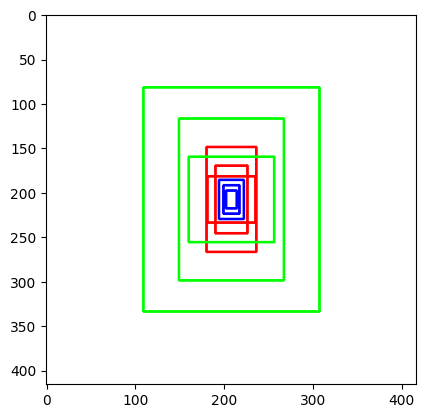

In [ ]:
'''
for box in new_boxes:
  cv2.rectangle(img,  ( int(box[0]), int(box[1]) ), ( int(box[2]), int(box[3]) ),
                (0,0,255), 1)
'''
all_anchors = []

for i in range(13):
  for j in range(13):
    anchors_per_cell = []
    if i == 6 and j==6:
      for box in new_centroids[6:]:

        cv2.rectangle(img, ( (i)*32 + 16 - int( (box[2]-box[0])/2  ) , (j)*32 + 16-int( (box[3]- box[1])/2 ) ),
               ((i)*32 +16 + int( (box[2] - box[0])/2 ), (j)*32 +16+ int( (box[3] - box[1])/2 )), (0,255,0),2)
        print([(i)*32 + 16 -int((box[2]-box[0])/2), (j) * 32 + 16 - int((box[3] - box[1])/2),
             (i)*32 +16 + int((box[2]-box[0])/2), (j)*32 +16 +int((box[3]-box[1])/2)])

        anchors_per_cell.append([ (i)*32 + 16 -int((box[2]-box[0])/2), (j)*32 + 16 - int((box[3]-box[1])/2),
                               (i)*32 + 16 + int((box[2]-box[0])/2), (j)*32 + 16+ int((box[3]-box[1])/2)])


    all_anchors.append(anchors_per_cell)
    if j==6 and i==6:
      break
  if j==6 and i==6:
    break

plt.imshow(img)



